### Grad-CAM Visualization

Grad-CAM highlights image regions that most influenced the model’s predicted class.
This helps interpret whether the network is focusing on tumor regions rather than unrelated artifacts.


In [1]:
import os
from pathlib import Path
import sys

os.chdir(Path("..").resolve())  # if notebook is in notebooks/

sys.path.append(str(Path("src").resolve()))


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def unnormalize(img_chw: torch.Tensor) -> np.ndarray:
    """
    img_chw: torch tensor [C,H,W] after Normalize
    returns: numpy image [H,W,C] in [0,1]
    """
    img = img_chw.detach().cpu().permute(1,2,0).numpy()  # HWC
    img = (img * IMAGENET_STD) + IMAGENET_MEAN
    img = np.clip(img, 0.0, 1.0)
    return img

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[:, class_idx]
        score.backward(retain_graph=True)

        # Grad-CAM
        grads = self.gradients          # [B, C, H, W]
        acts  = self.activations        # [B, C, H, W]
        weights = grads.mean(dim=(2,3), keepdim=True)  # [B, C, 1, 1]
        cam = (weights * acts).sum(dim=1, keepdim=True)  # [B, 1, H, W]
        cam = F.relu(cam)

        cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
        cam = cam[0,0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, class_idx


In [3]:
from collections import defaultdict
import torch

def collect_correct_examples(model, ds, device, max_per_class=3):
    model.eval()
    correct = defaultdict(list)

    with torch.no_grad():
        for i in range(len(ds)):
            x, y = ds[i]
            x_in = x.unsqueeze(0).to(device)
            logits = model(x_in)
            pred = logits.argmax(dim=1).item()

            if pred == int(y) and len(correct[int(y)]) < max_per_class:
                correct[int(y)].append(i)

            # stop early when we have enough for all classes
            if all(len(correct[c]) >= max_per_class for c in range(len(CLASS_NAMES))):
                break

    return correct

Using indices: [3, 4, 100, 101, 215, 216, 321, 322]


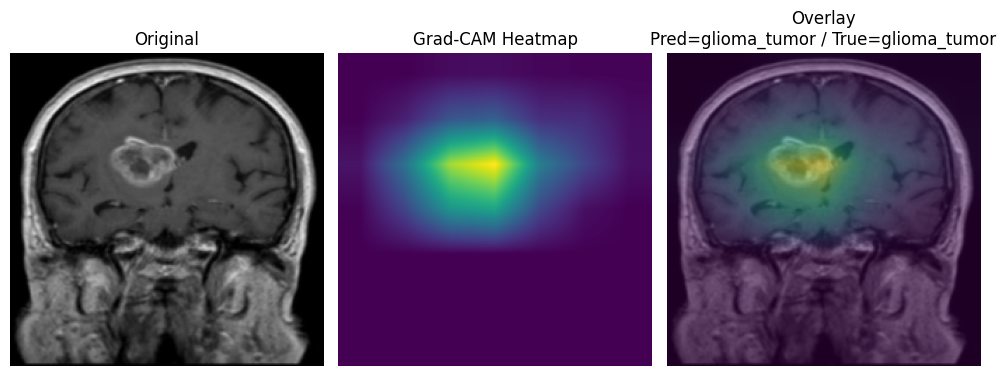

Saved: reports\figures\gradcam_best_aug_idx3_predglioma_tumor_trueglioma_tumor.png


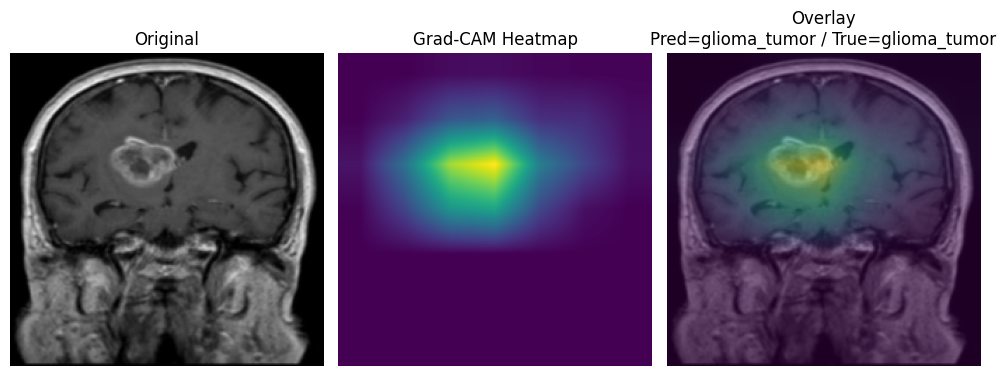

Saved: reports\figures\gradcam_best_aug_idx4_predglioma_tumor_trueglioma_tumor.png


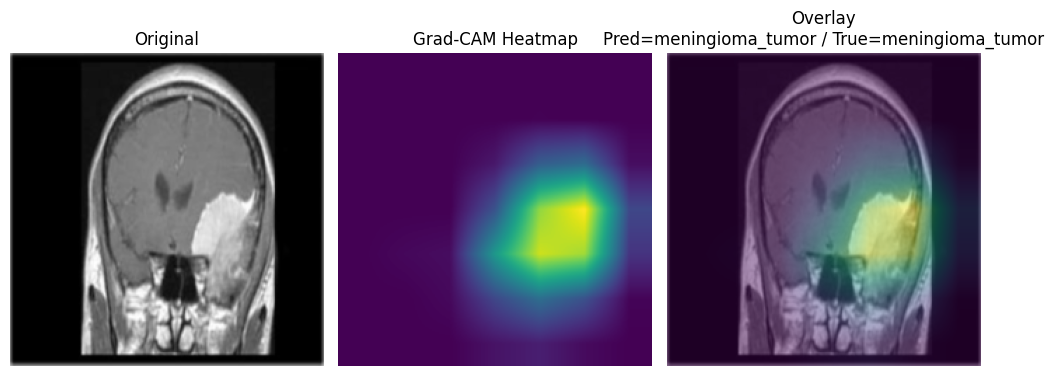

Saved: reports\figures\gradcam_best_aug_idx100_predmeningioma_tumor_truemeningioma_tumor.png


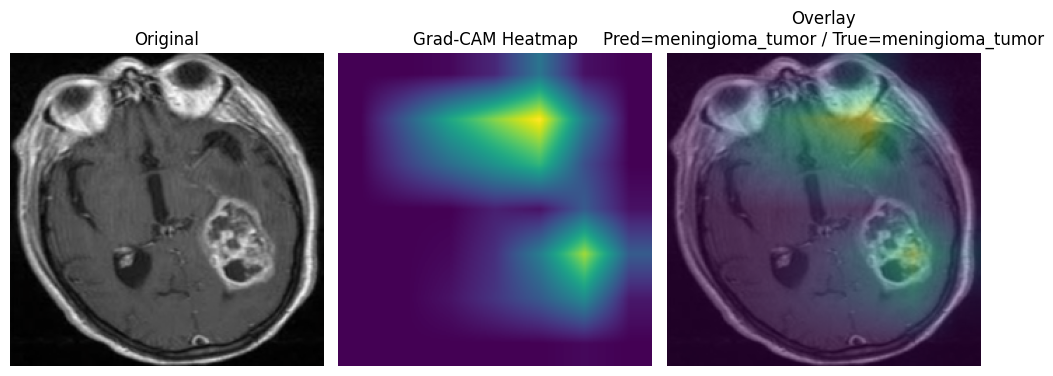

Saved: reports\figures\gradcam_best_aug_idx101_predmeningioma_tumor_truemeningioma_tumor.png


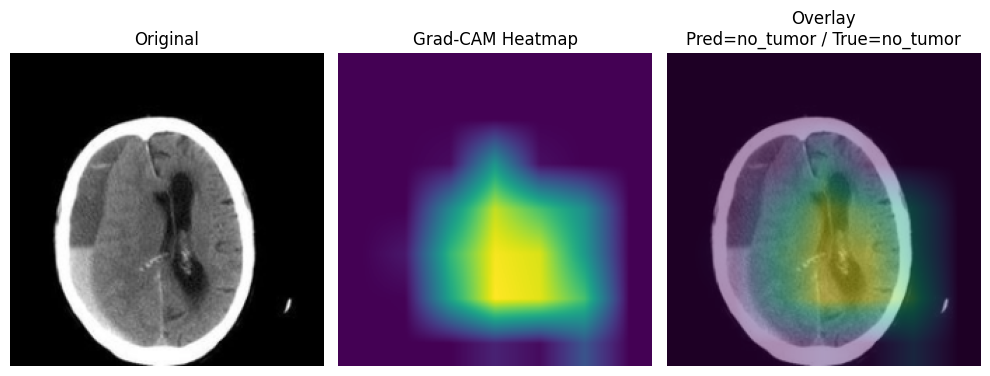

Saved: reports\figures\gradcam_best_aug_idx215_predno_tumor_trueno_tumor.png


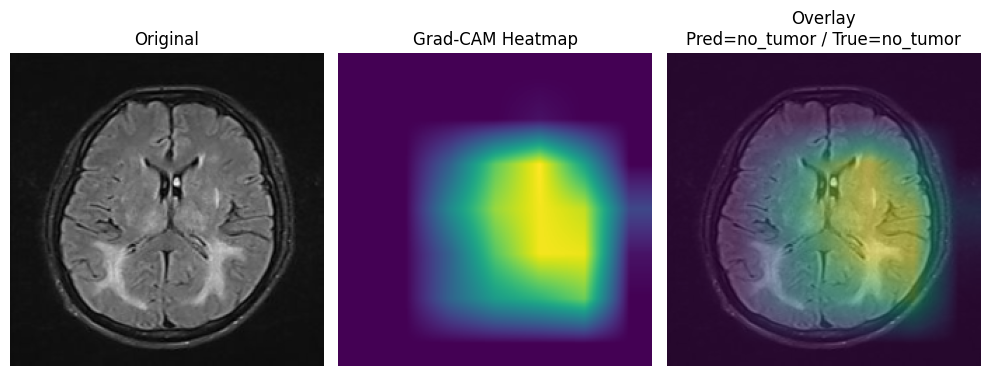

Saved: reports\figures\gradcam_best_aug_idx216_predno_tumor_trueno_tumor.png


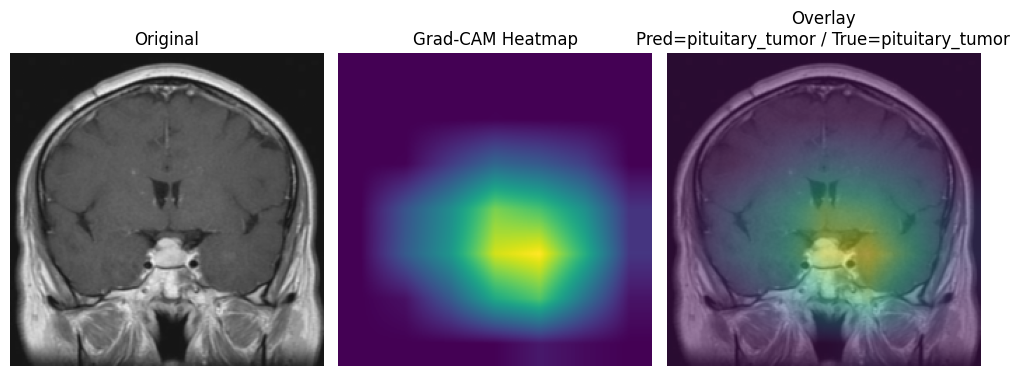

Saved: reports\figures\gradcam_best_aug_idx321_predpituitary_tumor_truepituitary_tumor.png


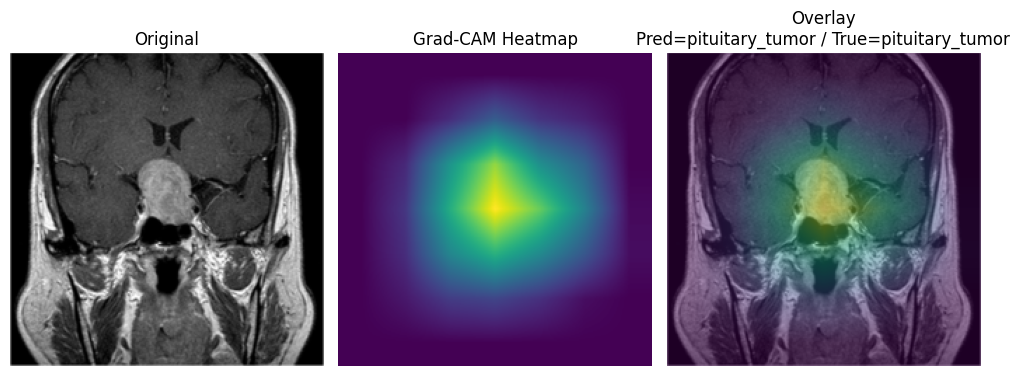

Saved: reports\figures\gradcam_best_aug_idx322_predpituitary_tumor_truepituitary_tumor.png


In [ ]:
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataset import FolderImageDataset, find_data_root, CLASS_NAMES
from model import build_resnet50

device = "cuda" if torch.cuda.is_available() else "cpu"
data_root = find_data_root()

# Choose which model you want Grad-CAM for:
weights_path = "runs/best_aug.pt"   # or "runs/best_noaug.pt"

# Output folder for report images
out_dir = Path("reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)

test_ds = FolderImageDataset(data_root, split="Testing", img_size=224, train=False)

model = build_resnet50(num_classes=4, pretrained=False).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# ResNet50 last conv block: layer4[-1].conv3
cam = GradCAM(model, model.layer4[-1].conv3)

# Collect correct examples per class (dict: class_id -> [idx, idx, ...])
correct_dict = collect_correct_examples(model, test_ds, device, max_per_class=2)

# Flatten into a single list of indices (ordered by class)
example_indices = []
for c in range(len(CLASS_NAMES)):
    example_indices.extend(correct_dict.get(c, []))

print("Using indices:", example_indices)

for idx in example_indices:
    x, y = test_ds[idx]            # x: [C,H,W]
    x_in = x.unsqueeze(0).to(device)

    heatmap, pred_idx = cam(x_in)

    # FIX: x is already CHW, do NOT do x[0]
    img = unnormalize(x)

    true_name = CLASS_NAMES[int(y)]
    pred_name = CLASS_NAMES[int(pred_idx)]

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"Overlay\nPred={pred_name} / True={true_name}")
    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.45)
    plt.axis("off")

    save_path = out_dir / f"gradcam_{Path(weights_path).stem}_idx{idx}_pred{pred_name}_true{true_name}.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

    print("Saved:", save_path)


Using indices: [3, 4, 100, 101, 215, 216, 321, 322]


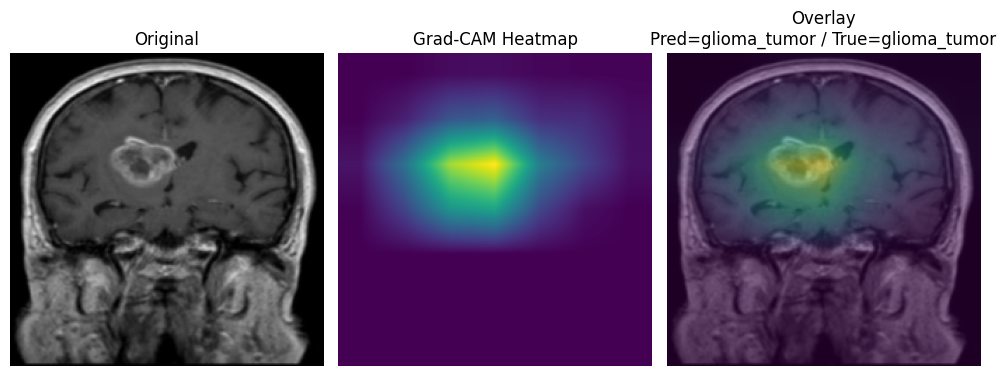

Saved: reports\figures\gradcam_best_aug_idx3_predglioma_tumor_trueglioma_tumor.png


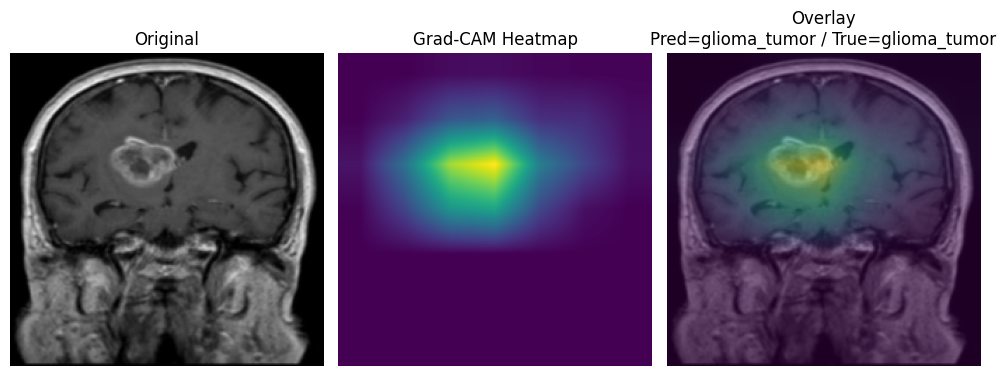

Saved: reports\figures\gradcam_best_aug_idx4_predglioma_tumor_trueglioma_tumor.png


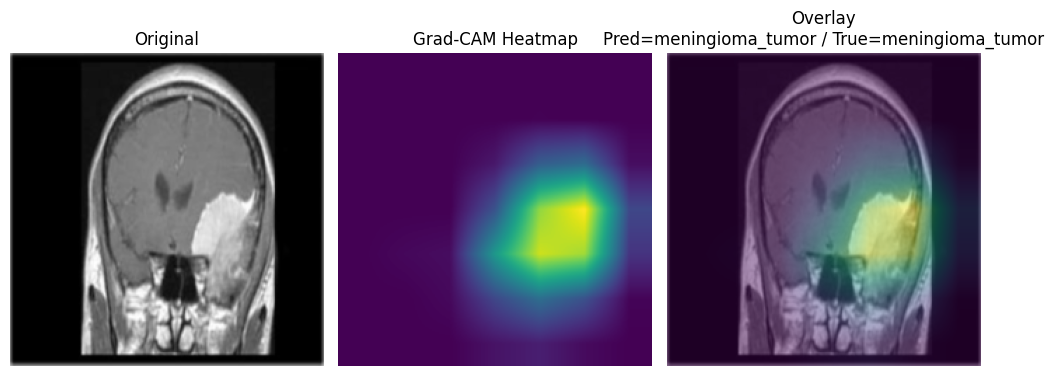

Saved: reports\figures\gradcam_best_aug_idx100_predmeningioma_tumor_truemeningioma_tumor.png


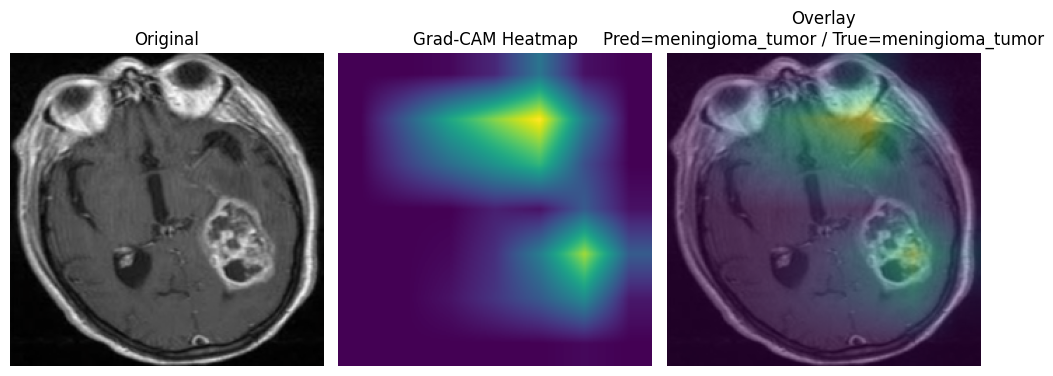

Saved: reports\figures\gradcam_best_aug_idx101_predmeningioma_tumor_truemeningioma_tumor.png


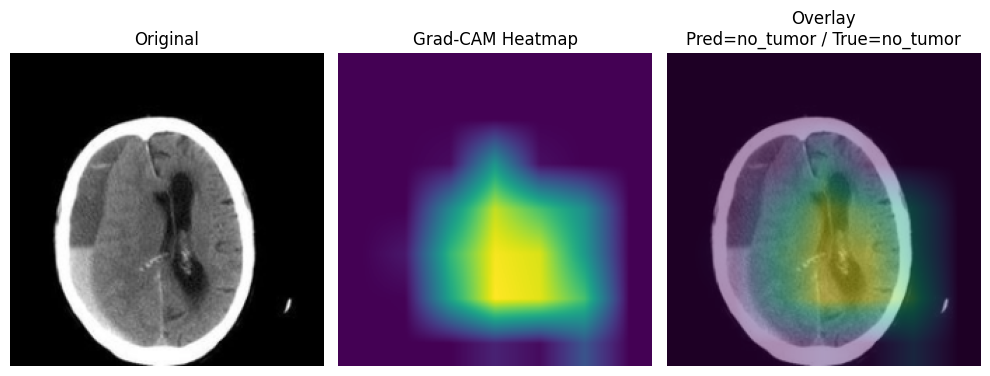

Saved: reports\figures\gradcam_best_aug_idx215_predno_tumor_trueno_tumor.png


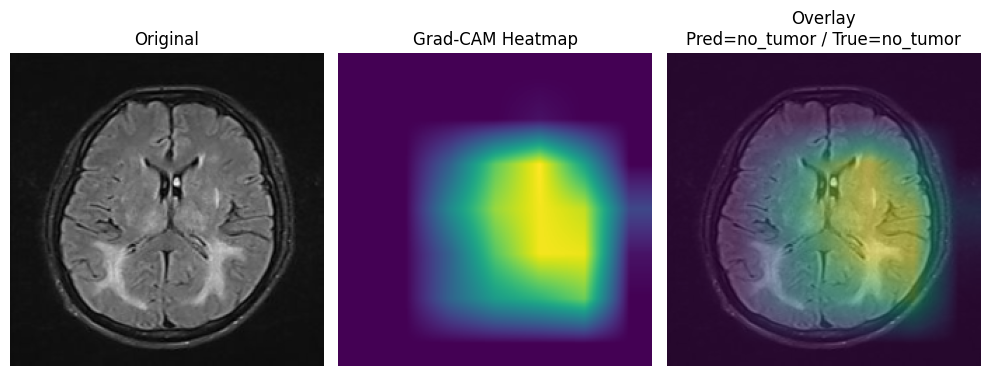

Saved: reports\figures\gradcam_best_aug_idx216_predno_tumor_trueno_tumor.png


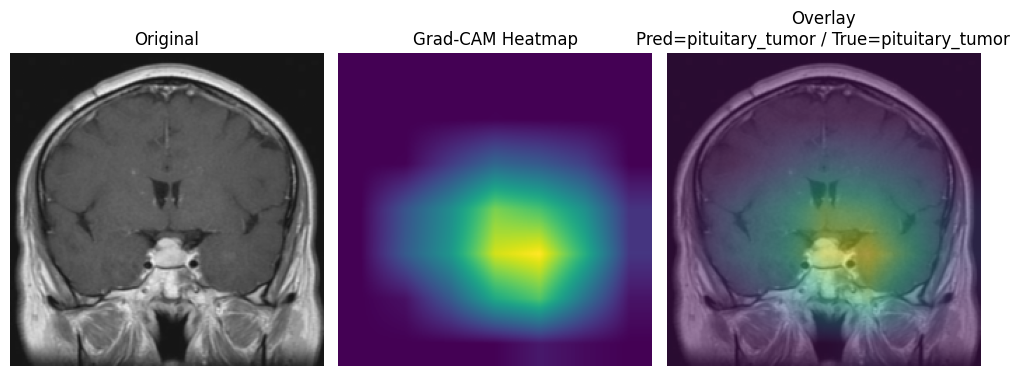

Saved: reports\figures\gradcam_best_aug_idx321_predpituitary_tumor_truepituitary_tumor.png


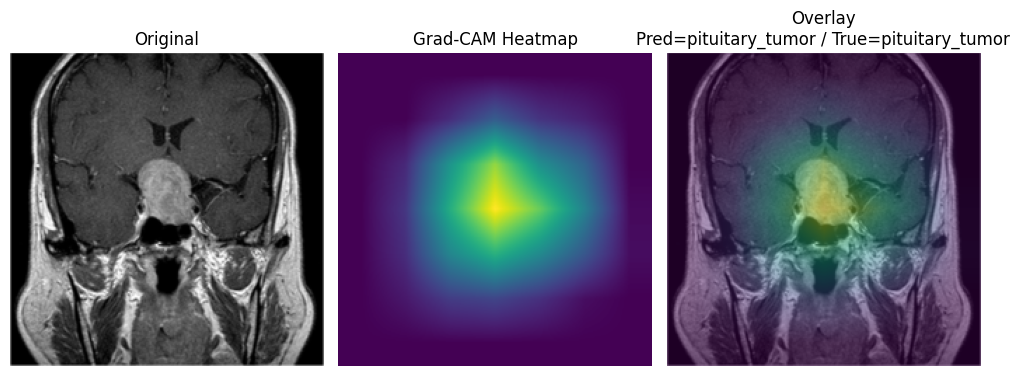

Saved: reports\figures\gradcam_best_aug_idx322_predpituitary_tumor_truepituitary_tumor.png


In [5]:
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataset import FolderImageDataset, find_data_root, CLASS_NAMES
from model import build_resnet50

device = "cuda" if torch.cuda.is_available() else "cpu"
data_root = find_data_root()

# Choose which model you want Grad-CAM for:
weights_path = "runs/best_aug.pt"   # or "runs/best_noaug.pt"

# Output folder for report images
out_dir = Path("reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)

test_ds = FolderImageDataset(data_root, split="Testing", img_size=224, train=False)

model = build_resnet50(num_classes=4, pretrained=False).to(device)
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

# ResNet50 last conv block: layer4[-1].conv3
cam = GradCAM(model, model.layer4[-1].conv3)

# Collect correct examples per class (dict: class_id -> [idx, idx, ...])
correct_dict = collect_correct_examples(model, test_ds, device, max_per_class=2)

# Flatten into a single list of indices (ordered by class)
example_indices = []
for c in range(len(CLASS_NAMES)):
    example_indices.extend(correct_dict.get(c, []))

print("Using indices:", example_indices)

for idx in example_indices:
    x, y = test_ds[idx]            # x: [C,H,W]
    x_in = x.unsqueeze(0).to(device)

    heatmap, pred_idx = cam(x_in)

    # FIX: x is already CHW, do NOT do x[0]
    img = unnormalize(x)

    true_name = CLASS_NAMES[int(y)]
    pred_name = CLASS_NAMES[int(pred_idx)]

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title(f"Overlay\nPred={pred_name} / True={true_name}")
    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.45)
    plt.axis("off")

    save_path = out_dir / f"gradcam_{Path(weights_path).stem}_idx{idx}_pred{pred_name}_true{true_name}.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

    print("Saved:", save_path)
